# Envs

In [1]:
"""
   Redo from DWF Python Example - Analog_Transistor.py
   Author:  Tran Le Phuong Lan
   Date:  2025-05-21

   Requires:                       
       Python 2.7, 3
"""

from ctypes import *

import math
import time
import sys
import os
from os import sep                # OS specific file path separators
import matplotlib.pyplot as plt
import numpy

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"): # on macOS
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else: # on Linux
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = sep + "usr" + sep + "share" + sep + "digilent" + sep + "waveforms" + sep + "samples" + sep + "py"

# Import constans
sys.path.append(constants_path)
import dwfconstants as constants

# code from analog_transistor.py but 

**the physical setup is**

- 1. W1 - OSC1

- 2. W2 - OSC2

In [17]:
print("Configuring device...")
# collector: 0V to 5V triangle output and 50Hz, 20ms
dwf.FDwfAnalogOutEnableSet(hdwf, 0, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 0, constants.funcTriangle)
dwf.FDwfAnalogOutPhaseSet(hdwf, 0, c_double(270.0))
dwf.FDwfAnalogOutFrequencySet(hdwf, 0, c_double(50))
dwf.FDwfAnalogOutOffsetSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutMasterSet(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 0, 0)

# base: 1V to 2V in 5 steps at 10Hz, 100ms total length
dwf.FDwfAnalogOutEnableSet(hdwf, 1, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 1, constants.funcCustom)
dwf.FDwfAnalogOutFrequencySet(hdwf, 1, c_double(10))
dwf.FDwfAnalogOutOffsetSet(hdwf, 1, c_double(1.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 1, c_double(0.5))
# values normalized to +-1 
# ChatGPT: using Python's ctypes module to create a C-style array of 5 double values.
rgSteps = (c_double*5)(-1.0, -0.5, 0, 0.5, 1.0) 
# The output value will be Offset + Sample*Amplitude
# The Sample = values in rgSteps
dwf.FDwfAnalogOutDataSet(hdwf, 1, rgSteps, len(rgSteps))
dwf.FDwfAnalogOutRunSet(hdwf, 1, c_double(0.1))
dwf.FDwfAnalogOutRepeatSet(hdwf, 1, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 0)

# scope: 5000 samples at 50kHz, 100ms
dwf.FDwfAnalogInChannelEnableSet(hdwf, 0, 1)
dwf.FDwfAnalogInChannelEnableSet(hdwf, 1, 1)
dwf.FDwfAnalogInFrequencySet(hdwf, c_double(50e3))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 0, c_double(10.0))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 1, c_double(10.0))
dwf.FDwfAnalogInBufferSizeSet(hdwf, 5000)
dwf.FDwfAnalogInTriggerSourceSet(hdwf, constants.trigsrcAnalogOut2) 
dwf.FDwfAnalogInTriggerPositionSet(hdwf, c_double(0.05)) # 5ms, trigger at first sample
dwf.FDwfAnalogInConfigure(hdwf, 1, 0)

print("Wait for the offset to stabilize...")
time.sleep(1)

print("Starting test...")
dwf.FDwfAnalogInConfigure(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 1)

sts = c_int()
while True:
    dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    time.sleep(0.001)
print("done")

rgc1 = (c_double*5000)()
rgc2 = (c_double*5000)()
dwf.FDwfAnalogInStatusData(hdwf, 0, rgc1, len(rgc1)) # get channel 1 data
dwf.FDwfAnalogInStatusData(hdwf, 1, rgc2, len(rgc2)) # get channel 2 data


Configuring device...
Wait for the offset to stabilize...
Starting test...
done


1

In [ ]:
plt.plot(numpy.arange(0, len(rgc1)), rgc1)

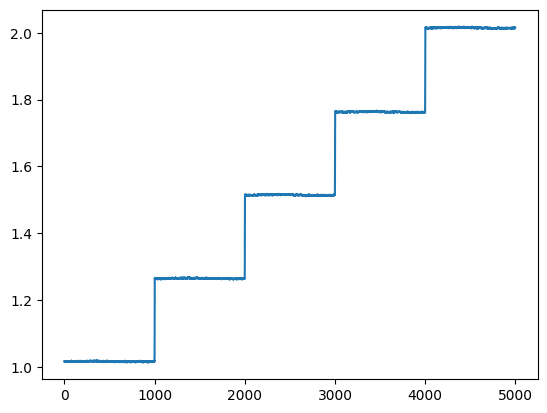

In [ ]:
plt.plot(numpy.arange(0, len(rgc2)), rgc2)

# Open the AD3

In [2]:
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("Version: "+str(version.value))

cdevices = c_int()
dwf.FDwfEnum(0, byref(cdevices))
print("Number of Devices: "+str(cdevices.value))

if cdevices.value == 0:
    print("no device detected")
    quit()

dwf.FDwfParamSet(constants.DwfParamOnClose, 0) # 0 = run, 1 = stop, 2 = shutdown

print("Opening first device")
hdwf = c_int()

# ChatGPT:
# byref() is a function from the ctypes module in Python, 
# which is used to pass a reference to a variable rather than its value
dwf.FDwfDeviceOpen(-1, byref(hdwf))

if hdwf.value == constants.hdwfNone.value:
    print("failed to open device")
    quit()

Version: b'3.24.2'
Number of Devices: 1
Opening first device


In [3]:
dwf.FDwfDeviceAutoConfigureSet(hdwf, 0) # 0 = the device will only be configured when FDwf###Configure is called

1

# Physical setup

## EXP1


Comprises of

- 1. W1 - OSC1

- 2. W2 - OSC2

## EXP 2

Comprises of

- 1. W1 - OSC1

# App

## EXP 1

- Purpose:

  - 1. checkout status and configurations of oscilloscope channels and wave generator channels, after configuration, after running

  - 2. learning how the oscilloscope is configured to record all the signals generated from the wavge generator.

### Osc

#### Configure

In [3]:
# scope: 5000 samples at 50kHz, 100ms
dwf.FDwfAnalogInChannelEnableSet(hdwf, 0, 1)
dwf.FDwfAnalogInChannelEnableSet(hdwf, 1, 1)

dwf.FDwfAnalogInFrequencySet(hdwf, c_double(50e3))

dwf.FDwfAnalogInChannelRangeSet(hdwf, 0, c_double(10.0))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 1, c_double(10.0))

dwf.FDwfAnalogInBufferSizeSet(hdwf, 5000)

dwf.FDwfAnalogInTriggerSourceSet(hdwf, constants.trigsrcAnalogOut2) 
dwf.FDwfAnalogInTriggerPositionSet(hdwf, c_double(0.05)) # 5ms, trigger at first sample

# (HDWF hdwf, int fReconfigure, int fStart)
dwf.FDwfAnalogInConfigure(hdwf, 1, 0)

print("Wait for the offset to stabilize...")
time.sleep(1)

Wait for the offset to stabilize...


#### Check osc configuration

In [5]:
# acquisition modes:
acq_mode_defs = {

        0: "acqmodeSingle",
        1: "acqmodeScanShift",
        2: "acqmodeScanScreen",
        3: "acqmodeRecord",
        4: "acqmodeOvers",
        5: "acqmodeSingle1"
}

In [8]:
# FDwfAnalogInAcquisitionModeGet(HDWF hdwf, ACQMODE *pacqmode)
acq_mode = c_int()
dwf.FDwfAnalogInAcquisitionModeGet(hdwf, byref(acq_mode))


1

In [ ]:
# convert c_int() to int python: a_cint = ctypes.c_int() -> a_int = a_cint.value
print(acq_mode_defs[acq_mode.value]) # by default, the acquisition mode is single

# "acqmodeSingle: Perform a single buffer acquisition and rearm the instrument for next capture after
# the data is fetched to host using FDwfAnalogInStatus or
# FDwfDigitalInStatus function. This is the default setting"

acqmodeSingle


In [ ]:
# FDwfAnalogInBufferSizeGet(HDWF hdwf, int *pnSize)
buf_size = c_int(0)
dwf.FDwfAnalogInBufferSizeGet(hdwf, byref(buf_size))
print(buf_size) # must return 5000 samples in the buffer bcz of the configuration above

c_int(5000)


### Wave Gen

#### configure wave gen

In [15]:
print("Configuring device...")

# collector: 0V to 5V triangle output and 50Hz, 20ms
# enable channel
# The following setup of FDwfAnalogOutNodeEnableSet is for normal use case of generating signal (i.e without modulation) 
#                         idxChannel AnalogOutNode   fMode
dwf.FDwfAnalogOutEnableSet(hdwf, 0, 1) 
# set function 
#                          idxChannel    AnalogOutNode func  
dwf.FDwfAnalogOutFunctionSet(hdwf, 0, constants.funcTriangle)
dwf.FDwfAnalogOutPhaseSet(hdwf, 0, c_double(270.0))
dwf.FDwfAnalogOutFrequencySet(hdwf, 0, c_double(50))
dwf.FDwfAnalogOutOffsetSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 0, c_double(2.5))
# FDwfAnalogOutMasterSet(HDWF hdwf, int idxChannel, int idxMaster)
dwf.FDwfAnalogOutMasterSet(hdwf, 0, 1)
# FDwfAnalogOutConfigure(HDWF hdwf, int idxChannel, int fStart)
# fStart: 0 stop, 1 start, 3 apply
dwf.FDwfAnalogOutConfigure(hdwf, 0, 0)

# base: 1V to 2V in 5 steps at 10Hz, 100ms total length
dwf.FDwfAnalogOutEnableSet(hdwf, 1, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 1, constants.funcCustom)
dwf.FDwfAnalogOutFrequencySet(hdwf, 1, c_double(10))
dwf.FDwfAnalogOutOffsetSet(hdwf, 1, c_double(1.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 1, c_double(0.5))
# values normalized to +-1 
rgSteps = (c_double*5)(-1.0, -0.5, 0, 0.5, 1.0)
dwf.FDwfAnalogOutDataSet(hdwf, 1, rgSteps, len(rgSteps))
dwf.FDwfAnalogOutRunSet(hdwf, 1, c_double(0.1)) # 0.1 second
# FDwfAnalogOutRepeatSet(HDWF hdwf, int idxChannel, int cRepeat)
dwf.FDwfAnalogOutRepeatSet(hdwf, 1, 1)
# FDwfAnalogOutConfigure(HDWF hdwf, int idxChannel, int fStart)
# fStart: 0 stop, 1 start, 3 apply
dwf.FDwfAnalogOutConfigure(hdwf, 1, 0)

Configuring device...


1

### Run and record

In [16]:
print("Starting test...")
dwf.FDwfAnalogInConfigure(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 1)

sts = c_int()
while True:
    dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    time.sleep(0.001)
print("done")

rgc1 = (c_double*5000)()
rgc2 = (c_double*5000)()
dwf.FDwfAnalogInStatusData(hdwf, 0, rgc1, len(rgc1)) # get channel 1 data
dwf.FDwfAnalogInStatusData(hdwf, 1, rgc2, len(rgc2)) # get channel 2 data

Starting test...
done


1

#### Instrument states after running, and collecting the recorded data

In [24]:
# instrument states
instr_state_defs = {
    0: "DwfStateReady",
    4: "DwfStateConfig",
    5: "DwfStatePrefill",
    1: "DwfStateArmed",
    7: "DwfStateWait",
    3: "DwfStateTriggered",
    3: "DwfStateRunning",
    6: "DwfStateNotDone",
    2: "DwfStateDone"
}

# check instrument status

## Oscilloscope
dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts))
print(f"status of the osc ch 1 after collecting the recorded data: {instr_state_defs[sts.value]}")

dwf.FDwfAnalogInStatus(hdwf, 0, byref(sts))
print(f"status of the osc ch 0 after collecting the recorded data: {instr_state_defs[sts.value]}")

# FDwfAnalogOutStatus(HDWF hdwf, int idxChannel, DwfState *psts)
dwf.FDwfAnalogOutStatus(hdwf, 0, byref(sts))
print(f"status of the wg ch 0 after collecting the recorded data: {instr_state_defs[sts.value]}")
dwf.FDwfAnalogOutStatus(hdwf, 1, byref(sts))
print(f"status of the wg ch 1 after collecting the recorded data: {instr_state_defs[sts.value]}")

status of the osc ch 1 after collecting the recorded data: DwfStateArmed
status of the osc ch 0 after collecting the recorded data: DwfStateArmed
status of the wg ch 0 after collecting the recorded data: DwfStateDone
status of the wg ch 1 after collecting the recorded data: DwfStateDone


#### Plot the recorded data

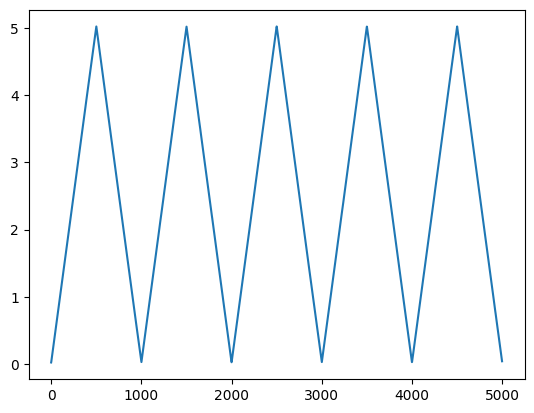

In [17]:
plt.plot(numpy.arange(0, len(rgc1)), rgc1)

In [18]:
plt.plot(numpy.arange(0, len(rgc2)), rgc2)

## EXP 2

- **REFERENCE**

[1] [online WaveForms app manual](https://digilent.com/reference/software/waveforms/waveforms-3/reference-manual?s[]=waveform&s[]=app&s[]=manual)

[2] Functions, Types and Constants definition of waveformsdk are found in (Linux) `/usr/include/digilent/waveforms/dwf.h` and `/usr/share/digilent/waveforms/samples/py/dwfconstants.py`

- **PURPOSE**: continuously reading in value from the wavegenerator using a oscilloscope, while the wave generator can still be changed to another configuration (for example, at the beginning the wave generator outputs sine wave, but later on, it outputs square wave)

  - To check out the configuration of wavegenerator when it is in idle states (Waiting, Ready, Stopped, or Done states).

  - Set the oscilloscope in single acquisition, 
    
    - could the two oscilloscope channel be independent with different Trigger configure? (My current guess is not, because we could not set the channel with the function: FDwfAnalogInTriggerSourceSet. -> we could test it out!)

    - According to WaveForms SDK Reference Manual, the by default, Trigger source is None. According to WaveForms manual (app), Trigger source None = the acquisition is started without a trigger. 

    - In the starting guide (https://digilent.com/reference/test-and-measurement/analog-discovery-3/getting-started), the Trigger is Auto. According to reference [1], the Trigger Auto = "when the trigger condition does not appear in 2 seconds, the acquisition is started automatically. **In repeated acquisition mode**, when the **instrument switches to auto trigger**, the **next acquisitions are made without waiting again to timeout while a trigger event does not occur** and the **configuration is not changed**. **When a new trigger event occurs, or the configuration is changed**, the **current acquisition will be finished** and the **next one will wait for the trigger again**. It is also the best mode to use if you are looking at many signals and do not want to bother setting the trigger each time"

    - acqmodeScanScreen, acqmodeScanShift: ignore Trigger.

    -  acqmodeScanShift (see example `../WaveSDK_examples/AnalogIn_ShiftScreen.py`): FIFO

    - acqmodeScanScreen : similar to a heart monitor display 

    - acqmodeRecord: stream data to host (?) is it like streaming options in WaveForms app manual reference (see `../README.md` - Reference - [8]) (see example `../WaveSDK_examples/AnalogIn_Record.py`). 

    - Maybe, using multi-thread programming technique in python to setup 1 thread for modifying the wavegenerator, another thread for recording the wave + save the recorded into file. The recording can use acqmodeScanShift (see example `../WaveSDK_examples/AnalogIn_ShiftScreen.py`) as an example. (? What is the difference between acqmodeScanShift, acqmodeRecord -> scanshift ignores trigger, while record still follows the trigger)
  
- **SOLUTION** is in section **Multithread, Multiprocess practice - Try measurment with multithread -Multithread the copy `AnalogIn_ShiftScreen.py`** (below) 


# Close AD3

In [105]:
dwf.FDwfDeviceCloseAll()

1

# Mutithread, Mutiprocess practice

**REFERENCE**

[1] https://www.geeksforgeeks.org/multithreading-python-set-1/

[2] https://www.dataquest.io/blog/multithreading-in-python/

[3] [Logging python module](https://realpython.com/python-logging/) 

[4] [Mutithread from realpython](https://realpython.com/intro-to-python-threading/)

- [4.1] [Kill a python thread](https://www.geeksforgeeks.org/python-different-ways-to-kill-a-thread/)

[5] [Mutiprocesses great method for jupyternotebook](https://discourse.jupyter.org/t/running-a-cell-in-a-background-thread/12267/2)

[6] [How to stop a process started by the multiprocess python](https://stackoverflow.com/questions/1231599/python-multiprocessing-exit-elegantly-how)

## Example from [3] 

In [15]:
import logging
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")
logging.warning("Remain calm!")

10:20:18: Remain calm!


## Example from [4]

In [2]:

import threading
import time

def thread_function(name):
    logging.info("Thread %s: starting", name)
    time.sleep(2)
    logging.info("Thread %s: finishing", name)

In [3]:
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

logging.info("Main    : before creating thread")
x = threading.Thread(target=thread_function, args=(1,))
logging.info("Main    : before running thread")
x.start()
logging.info("Main    : wait for the thread to finish")
# x.join()
logging.info("Main    : all done")

08:57:17: Main    : before creating thread
08:57:17: Main    : before running thread
08:57:17: Thread 1: starting
08:57:17: Main    : wait for the thread to finish
08:57:17: Main    : all done


08:57:19: Thread 1: finishing


In [4]:
def thread_function_v2(name, stop):
    logging.info("Thread %s: starting", name)
    while True:
        logging.info("Thread %s: in loop", name)
        time.sleep(2)
        if stop():
            break

In [6]:
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

logging.info("Main    : before creating thread")
stop_threads = False
x = threading.Thread(target=thread_function_v2, args=(1, lambda: stop_threads, ))
x.daemon = True

logging.info("Main    : before running thread")
x.start()
logging.info("Main    : wait for the thread to finish")
# x.join()
logging.info("Main    : all done")

08:57:56: Main    : before creating thread
08:57:56: Main    : before running thread
08:57:56: Thread 1: starting
08:57:56: Main    : wait for the thread to finish
08:57:56: Thread 1: in loop
08:57:56: Main    : all done


08:57:58: Thread 1: in loop
08:58:00: Thread 1: in loop
08:58:02: Thread 1: in loop
08:58:04: Thread 1: in loop
08:58:06: Thread 1: in loop
08:58:08: Thread 1: in loop


In [7]:
x.is_alive()

True

In [8]:
stop_threads= True

## Try measurment with multithread

**PROBLEM**

- using multithread to run record with oscilloscope continuous, at the same time, changing the wave generator output signal: in jupyternotebook, we stuck at the cell running the thread of osc record (which has `while true`), and can not take back the control in the current jupyterbook. => **WRONG!** because inside the thread there was no pause moment to take back the control from the main thread -> see the example of section **Example [4] - `thread_function_v2`** (above)

- Previously, even copy past the exact the content of `AnalogIn_ShiftScreen.py`, the result of recording from oscilloscope is status =0, rgdSamples is full of 0's. That **because the device handle** which is **already established** in section **Open the AD3** above was **overwritten by the `hdwf = c_int()` in the following cells!** . **DO NOT REPEAT THIS MISTAKE** 

**Possible Solution**

- see reference [5], and the section **Example from [5]** below

### Copy from `AnalogIn_ShiftScreen.py` 

- `AnalogIn_ShiftScreen.py`: in the same folder of this file

In [ ]:
# hdwf = c_int() # wrong bcz we reset the device handle !! 
sts = c_byte()
hzAcq = c_double(200)
nSamples = 1000
rgdSamples = (c_double*nSamples)()
cValid = c_int(0)

print("Generating sine wave...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), c_int(0), c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), c_int(0), c_int(1)) #sine
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), c_int(0), c_double(2))
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(1))

#set up acquisition
dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_int(1))
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(5))
dwf.FDwfAnalogInAcquisitionModeSet(hdwf, c_int(1)) #acqmodeScanShift
dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(nSamples))
dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0))

#wait at least 2 seconds for the offset to stabilize
time.sleep(2)

#begin acquisition
dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

plt.axis([0, len(rgdSamples), -2.5, 2.5])
plt.ion()
hl, = plt.plot([], [])
hl.set_xdata(range(0, len(rgdSamples)))

start = time.time()
print("Press Ctrl+C to stop")
try:
    while True: #time.time()-start < 10:
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))

        dwf.FDwfAnalogInStatusSamplesValid(hdwf, byref(cValid))

        dwf.FDwfAnalogInStatusData(hdwf, c_int(0), byref(rgdSamples), cValid) # get channel 1 data
        #dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples), cValid) # get channel 2 data
        #print(cValid.value)
        print(f"{sts=}")
        print(f"{cValid.value=}")
        print(f"{rgdSamples[0:10]=}")
        hl.set_ydata(rgdSamples)
        plt.draw()
        plt.pause(0.1)
except KeyboardInterrupt:
    pass

In [32]:
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(0))

1

### Multithread the copy `AnalogIn_ShiftScreen.py`

In [4]:
import threading
import time
import logging

format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

In [ ]:
# int fsfilter;
# FDwfAnalogInChannelFilterInfo(h, &fsfilter)
# if(IsBitSet(fsfilter, filterAverage)){
#  FDwfAnalogInChannelFilterSet(hdwf, 0, filterAverage)
# }

In [24]:
out_ch = c_int(0)
print("Generating sine wave...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, out_ch, c_int(0), c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, out_ch, c_int(0), c_int(1)) #sine
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, out_ch, c_int(0), c_double(1))
# dwf.FDwfAnalogOutRunSet(hdwf, out_ch, c_double(5))
# dwf.FDwfAnalogOutRepeatSet(hdwf, out_ch, 1)
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, out_ch, c_int(0), c_double(2))
# FDwfAnalogOutOffsetSet(HDWF hdwf, int idxChannel, double vOffset)
dwf.FDwfAnalogOutOffsetSet(hdwf, out_ch, c_double(1))
dwf.FDwfAnalogOutConfigure(hdwf, out_ch, c_int(3))

Generating sine wave...


1

In [68]:
dwf.FDwfAnalogOutConfigure(hdwf, out_ch, c_int(0))

1

In [25]:
# FDwfAnalogOutStatus(HDWF hdwf, int idxChannel, DwfState *psts)
p_o_sts = c_ubyte(0)
dwf.FDwfAnalogOutStatus(hdwf, out_ch, byref(p_o_sts))
print(f"{p_o_sts=}")

# get the Idle state Info
pfsidle = c_int()
# FDwfAnalogOutIdleInfo(HDWF hdwf, int idxChannel, int *pfsidle)
# information of pfsidle is constant DwfAnalogOutIdle in dwf.h
dwf.FDwfAnalogOutIdleInfo(hdwf, out_ch, byref(pfsidle))
print(f"{pfsidle.value=}")

# Get analogoutIdle 
pidle = c_int()
# FDwfAnalogOutIdleGet(HDWF hdwf, int idxChannel, DwfAnalogOutIdle *pidle);
dwf.FDwfAnalogOutIdleGet(hdwf, out_ch, byref(pidle))
print(f"{pidle=}")

# Get the offset set by default
# FDwfAnalogOutOffsetGet(HDWF hdwf, int idxChannel, double *pvoltsOffset);
pvoltsOffset = c_double()
dwf.FDwfAnalogOutOffsetGet(hdwf, out_ch, byref(pvoltsOffset))
print(f"{pvoltsOffset=}")

# set the idle state
# FDwfAnalogOutIdleSet(HDWF hdwf, int idxChannel, DwfAnalogOutIdle idle);
idle = c_int(1)
dwf.FDwfAnalogOutIdleSet(hdwf, out_ch, idle)

# set the offset level
# FDwfAnalogOutOffsetSet(HDWF hdwf, int idxChannel, double vOffset)
dwf.FDwfAnalogOutOffsetSet(hdwf, out_ch, c_double(1))

p_o_sts=c_ubyte(3)
pfsidle.value=14
pidle=c_long(1)
pvoltsOffset=c_double(0.9997358103048555)


1

In [26]:
dwf.FDwfAnalogOutConfigure(hdwf, out_ch, c_int(3))

1

In [27]:
dwf.FDwfAnalogOutIdleGet(hdwf, out_ch, byref(pidle))
print(f"{pidle=}")

pidle=c_long(1)


In [31]:
dwf.FDwfAnalogOutConfigure(hdwf, out_ch, c_int(1))

1

In [28]:
import json
# store the record in a file
restart_record = True

if restart_record == True:
    f = open("../data/output.jsonl", 'w')
else:
    f = open("../data/output.jsonl", 'a')

In [29]:
def record_function(hdwf, osc_ch, hzAcq, nSamples, stop):

    rgdSamples = (c_double*nSamples)()
    sts = c_byte()
    cValid = c_int()

    #set up acquisition
    dwf.FDwfAnalogInChannelEnableSet(hdwf, osc_ch, c_int(1))
    dwf.FDwfAnalogInChannelRangeSet(hdwf, osc_ch, c_double(5))
    dwf.FDwfAnalogInAcquisitionModeSet(hdwf, c_int(1)) #acqmodeScanShift
    dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
    dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(nSamples))
    # allow configure, and stop the channel
    dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0)) 

    #wait at least 2 seconds for the offset to stabilize
    time.sleep(2)

    #begin acquisition
    # DO NOT allow configure, and run the channel
    dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1)) 

    idx = 0
    logging.info("starting record process")
   
    while True: #time.time()-start < 10:
        logging.info("In the record loop")
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
        

        dwf.FDwfAnalogInStatusSamplesValid(hdwf, byref(cValid))

        dwf.FDwfAnalogInStatusData(hdwf, osc_ch, byref(rgdSamples), cValid) # get channel 1 data
        #dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples), cValid) # get channel 2 data
        logging.info(f"{sts=}")
        logging.info(f"{cValid.value=}")
        logging.info(f"{rgdSamples[0:10]}")
        
        # write to a file
        json_obj = {"id": idx, "value": list(rgdSamples)}
        f.write(json.dumps(json_obj) + '\n')

        time.sleep(0.1)

        if stop():
            # allow reconfigure, and stop the channel
            dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0))
            f.close()
            break
        

In [ ]:
sts = c_byte()
hzAcq = c_double(200)
nSamples = 1000


logging.info("Main    : before starting recording")
stop_threads = False
x = threading.Thread(target=record_function, args=(hdwf, c_int(0), hzAcq, nSamples, lambda: stop_threads,))
logging.info("Main    : before running recording")
x.start()
logging.info("Main    : change configuration of wavegenerator")
# x.join()
logging.info("Main    : all done")

20:05:18: Main    : before starting recording
20:05:18: Main    : before running recording
20:05:18: Main    : change configuration of wavegenerator
20:05:18: Main    : all done


20:05:20: starting record process
20:05:20: In the record loop
20:05:20: sts=c_byte(3)
20:05:20: cValid.value=0
20:05:20: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
20:05:20: In the record loop
20:05:20: sts=c_byte(3)
20:05:20: cValid.value=21
20:05:20: [2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5576201029826726, 2.5171160613722687, 2.475589587643544]
20:05:20: In the record loop
20:05:20: sts=c_byte(3)
20:05:20: cValid.value=43
20:05:20: [2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5576201029826726, 2.5171160613722687, 2.475589587643544]
20:05:21: In the record loop
20:05:21: sts=c_byte(3)
20:05:21: cValid.value=64
20:05:21: [2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5771249618552554, 2.5576201029826726,

In [37]:
stop_threads = True

In [36]:
# Stop the generator
dwf.FDwfAnalogOutConfigure(hdwf, out_ch, c_int(0))

1

In [17]:
# reconfigure the generator

# FDwfAnalogOutOffsetSet(HDWF hdwf, int idxChannel, double vOffset)
dwf.FDwfAnalogOutOffsetSet(hdwf, out_ch, c_double(0))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), c_int(0), c_ubyte(2)) # funcSquare   = c_ubyte(2)
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(3))

1

In [18]:
# Get analogoutIdle 
pidle = c_int()
# FDwfAnalogOutIdleGet(HDWF hdwf, int idxChannel, DwfAnalogOutIdle *pidle);
dwf.FDwfAnalogOutIdleGet(hdwf, out_ch, byref(pidle))
print(f"{pidle=}")

pidle=c_long(1)


In [35]:
# Start the generator
dwf.FDwfAnalogOutConfigure(hdwf, out_ch, c_int(1))

1

#### Plot the recording (must use animation)

In [134]:
# Loading the .jsonl for plotting

# Path to your .jsonl file
jsonl_path = "../data/output.jsonl"

# Initialize lists to store the time and value

with open(jsonl_path, 'r') as f:
    lines = f.readlines()

In [19]:
print(type(lines),
      len(lines),
      type(lines[0]),
)

data = json.loads(lines[0])

print(data['value'])

<class 'list'> 715 <class 'str'>
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

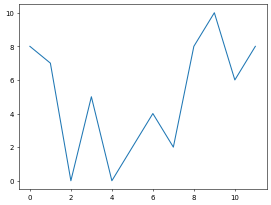

In [20]:
# animation
# reference: https://stackoverflow.com/questions/43445103/inline-animations-in-jupyter

import matplotlib.animation
import matplotlib.pyplot as plt
from itertools import count
import random

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 50

fig, ax = plt.subplots()
x_value = []
y_value = []
index = count()
def animate(t):
    x_value.append(next(index))
    y_value.append(random.randint(0,10))
    ax.cla()
    ax.plot(x_value,y_value)
    # ax.set_xlim(0,10)

matplotlib.animation.FuncAnimation(fig, animate, frames=10, interval = 500)

In [38]:
import json
# Path to your .jsonl file
jsonl_path = "../data/output.jsonl"
# index = count()
with open(jsonl_path, 'r') as f:
    lines = f.readlines()
# convert lines to appropriate data
data = []
for idx, elem in enumerate(lines):
    json_elem = json.loads(elem)
    data.append(json_elem)

In [21]:
print(
    data[10]['value']
)

[0.0016184558049659125, 0.0016184558049659125, 0.0016184558049659125, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0014611585559934697, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0016184558049659125, 0.0015398071804796911, 0.0016184558049659125, 0.0016184558049659125, 0.0016184558049659125, 0.0015398071804796911, 0.0016184558049659125, 0.0016184558049659125, 0.0015398071804796911, 0.0015398071804796911, 0.0016184558049659125, 0.0016184558049659125, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0014611585559934697, 0.0014611585559934697, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0015398071804796911, 0.0016184558049659125, 0.0016184558049659125, 0.0015398071804796911, 0.0015398071804796911, 0.0016184558049659125, 0.00161845

20:13:28: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


idx_cn=0
idx_cn=1
idx_cn=2
idx_cn=3
idx_cn=4
idx_cn=5
idx_cn=6
idx_cn=7
idx_cn=8
idx_cn=9
idx_cn=10
idx_cn=11
idx_cn=12
idx_cn=13
idx_cn=14
idx_cn=15
idx_cn=16
idx_cn=17
idx_cn=18
idx_cn=19
idx_cn=20
idx_cn=21
idx_cn=22
idx_cn=23
idx_cn=24
idx_cn=25
idx_cn=26
idx_cn=27
idx_cn=28
idx_cn=29
idx_cn=30
idx_cn=31
idx_cn=32
idx_cn=33
idx_cn=34
idx_cn=35
idx_cn=36
idx_cn=37
idx_cn=38
idx_cn=39
idx_cn=40
idx_cn=41
idx_cn=42
idx_cn=43
idx_cn=44
idx_cn=45
idx_cn=46
idx_cn=47
idx_cn=48
idx_cn=49
idx_cn=50
idx_cn=51
idx_cn=52
idx_cn=53
idx_cn=54
idx_cn=55
idx_cn=56
idx_cn=57
idx_cn=58
idx_cn=59
idx_cn=60
idx_cn=61
idx_cn=62
idx_cn=63
idx_cn=64
idx_cn=65
idx_cn=66
idx_cn=67
idx_cn=68
idx_cn=69
idx_cn=70
idx_cn=71
idx_cn=72
idx_cn=73
idx_cn=74
idx_cn=75
idx_cn=76
idx_cn=77
idx_cn=78
idx_cn=79
idx_cn=80
idx_cn=81
idx_cn=82
idx_cn=83
idx_cn=84
idx_cn=85
idx_cn=86
idx_cn=87
idx_cn=88
idx_cn=89
idx_cn=90
idx_cn=91
idx_cn=92
idx_cn=93
idx_cn=94
idx_cn=95
idx_cn=96
idx_cn=97
idx_cn=98
idx_cn=99
idx_cn=100

idx_cn=540


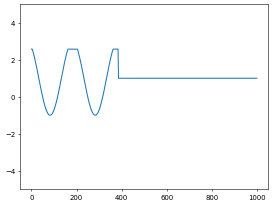

In [40]:
%matplotlib inline

import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import count


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 50

fig, ax = plt.subplots()

# ax.set_ylim((-5, 5))
  # Clear the subplot conte
ax.cla()

x_value = []
y_value = []

# Path to your .jsonl file
jsonl_path = "../data/output.jsonl"

with open(jsonl_path, 'r') as f:
    lines = f.readlines()
# convert lines to appropriate data
data = []
for idx, elem in enumerate(lines):
    json_elem = json.loads(elem)
    data.append(json_elem)

index = count()

def animate(t):

    idx_cn = next(index)
    print(f"{idx_cn=}")

    if idx_cn < len(data):
        x_axis = np.arange(0, len(data[idx_cn]['value']), 1)
        y_axis = data[idx_cn]['value']
        
        # Clear the subplot content
        ax.cla() 

        # ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
    
        ax.plot(x_axis, y_axis)
   

# frames = number of total pictures
# interval = time between two adjacent frame
matplotlib.animation.FuncAnimation(fig, animate, frames=len(data), interval = 500)

## Example from [5]

In [ ]:
# Long running cell
import multiprocessing, time

def network_call():
    for i in range(20):
        print(i)
        time.sleep(10)
    
multiprocessing.Process(target=network_call).start()

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [7]:
# Another cell
print("Output from another cell")

Output from another cell


In [8]:
# Another cell
print("Output from another cell")

Output from another cell


## Try measurment with multiprocess

In [3]:
import logging
import multiprocessing, time, signal
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")
logging.warning("Remain calm!")

23:03:20: Remain calm!


In [ ]:


# hdwf = c_int() # wrong bcz we reset the device handle !! 

print("Generating sine wave...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), c_int(0), c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), c_int(0), c_int(1)) #sine
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), c_int(0), c_double(2))
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(1))

Generating sine wave...


0

In [ ]:
def record_function(hdwf, osc_ch, hzAcq, nSamples):

    #set up acquisition
    dwf.FDwfAnalogInChannelEnableSet(hdwf, osc_ch, c_int(1))
    dwf.FDwfAnalogInChannelRangeSet(hdwf, osc_ch, c_double(5))
    dwf.FDwfAnalogInAcquisitionModeSet(hdwf, c_int(1)) #acqmodeScanShift
    dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
    dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(nSamples))
    dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0))

    #wait at least 2 seconds for the offset to stabilize
    time.sleep(2)

    #begin acquisition
    dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

    logging.info("starting record process")
    
    sts = c_ubyte()
    cValid = c_int()
    rgdSamples = (c_double*nSamples)()
    
    while True: #time.time()-start < 10:
        logging.info("In the record loop")
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
        logging.info(f"{sts=}")

        dwf.FDwfAnalogInStatusSamplesValid(hdwf, byref(cValid))

        dwf.FDwfAnalogInStatusData(hdwf, osc_ch, byref(rgdSamples), cValid) # get channel 1 data
        #dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples), cValid) # get channel 2 data
        logging.info(f"{cValid.value=}")
        len_rs = len(rgdSamples)
        logging.info(f"{len_rs=}")
        values = rgdSamples[len_rs-10:-1]
        logging.info(f"{values=}")
        time.sleep(20) # must have this pause, to be able to take control back in jupyternotebook

In [ ]:
# mp_context = multiprocessing.get_context('spawn') # ERROR (why?)

# sts = c_byte()
hzAcq = c_double(200)
nSamples = 1000
# rgdSamples = (c_double*nSamples)()

p = multiprocessing.Process(target=record_function, args=(hdwf, c_int(0), nSamples))
p.start()

23:09:40: starting record process
23:09:40: In the record loop
23:09:40: sts=c_ubyte(0)
23:09:40: cValid.value=0
23:09:40: len_rs=1000


23:09:40: values=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


23:10:00: In the record loop
23:10:00: sts=c_ubyte(0)
23:10:00: cValid.value=0
23:10:00: len_rs=1000
23:10:00: values=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
23:10:20: In the record loop
23:10:20: sts=c_ubyte(0)
23:10:20: cValid.value=0
23:10:20: len_rs=1000
23:10:20: values=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
23:10:40: In the record loop
23:10:40: sts=c_ubyte(0)
23:10:40: cValid.value=0
23:10:40: len_rs=1000
23:10:40: values=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
23:11:00: In the record loop
23:11:00: sts=c_ubyte(0)
23:11:00: cValid.value=0
23:11:00: len_rs=1000
23:11:00: values=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [25]:
p.terminate()

In [26]:
print(p, p.is_alive())

<Process name='Process-8' pid=61643 parent=60986 stopped exitcode=-SIGTERM> False
